<a href="https://colab.research.google.com/github/SasidharaSrivatchasa/Quora-Question-Pairs---Semantic-Similarity-Detection/blob/main/Quora_Question_Pairs_Semantic_Similarity_Detection_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import Required Libraries
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, concatenate
from tensorflow.keras.optimizers import Adam

nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Load Dataset
df = pd.read_csv('/content/train.csv')
df = df.dropna()  # Drop rows with null values
df = df[['question1', 'question2', 'is_duplicate']]
df.head()


,question1,question2,is_duplicate
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
# Text Cleaning
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)  # This Removes punctuation
    text = re.sub(r'\d+', '', text)      # This Removes numbers
    text = " ".join([word for word in text.split() if word not in stop_words])
    return text

df['question1'] = df['question1'].apply(clean_text)
df['question2'] = df['question2'].apply(clean_text)


In [ ]:
# Tokenization and Padding
MAX_NUM_WORDS = 20000
MAX_SEQUENCE_LENGTH = 30

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(pd.concat([df['question1'], df['question2']]))

q1_seq = tokenizer.texts_to_sequences(df['question1'])
q2_seq = tokenizer.texts_to_sequences(df['question2'])

q1_data = pad_sequences(q1_seq, maxlen=MAX_SEQUENCE_LENGTH)
q2_data = pad_sequences(q2_seq, maxlen=MAX_SEQUENCE_LENGTH)
labels = np.array(df['is_duplicate'])

X_train_q1, X_test_q1, X_train_q2, X_test_q2, y_train, y_test = train_test_split(
    q1_data, q2_data, labels, test_size=0.2, random_state=42)


In [ ]:
# Define the Model
embedding_dim = 128

input_q1 = Input(shape=(MAX_SEQUENCE_LENGTH,))
input_q2 = Input(shape=(MAX_SEQUENCE_LENGTH,))

embedding = Embedding(input_dim=MAX_NUM_WORDS, output_dim=embedding_dim, input_length=MAX_SEQUENCE_LENGTH)

encoded_q1 = embedding(input_q1)
encoded_q2 = embedding(input_q2)

shared_lstm = LSTM(64)

q1_output = shared_lstm(encoded_q1)
q2_output = shared_lstm(encoded_q2)

merged = concatenate([q1_output, q2_output])
merged = Dense(64, activation='relu')(merged)
merged = Dropout(0.3)(merged)
output = Dense(1, activation='sigmoid')(merged)

model = Model(inputs=[input_q1, input_q2], outputs=output)
model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 30, 128)   │  2,560,000 │ input_layer[0][0… │
│ (Embedding)         │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 64)        │     49,408 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ lstm[0][0],       │
│ (Concatenate)       │                   │            │ lstm[1][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      8,256 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         65 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,617,729 (9.99 MB)

 Trainable params: 2,617,729 (9.99 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the Model
history = model.fit([X_train_q1, X_train_q2], y_train,
                    validation_split=0.1,
                    epochs=5,
                    batch_size=512)


Epoch 1/5
569/569 ━━━━━━━━━━━━━━━━━━━━ 233s 402ms/step - accuracy: 0.7102 - loss: 0.5649 - val_accuracy: 0.7666 - val_loss: 0.4793
Epoch 2/5
569/569 ━━━━━━━━━━━━━━━━━━━━ 238s 360ms/step - accuracy: 0.7934 - loss: 0.4352 - val_accuracy: 0.7857 - val_loss: 0.4550
Epoch 3/5
569/569 ━━━━━━━━━━━━━━━━━━━━ 256s 350ms/step - accuracy: 0.8280 - loss: 0.3717 - val_accuracy: 0.7921 - val_loss: 0.4507
Epoch 4/5
569/569 ━━━━━━━━━━━━━━━━━━━━ 206s 356ms/step - accuracy: 0.8521 - loss: 0.3266 - val_accuracy: 0.7929 - val_loss: 0.4819
Epoch 5/5
569/569 ━━━━━━━━━━━━━━━━━━━━ 265s 362ms/step - accuracy: 0.8736 - loss: 0.2836 - val_accuracy: 0.7971 - val_loss: 0.5000


2527/2527 ━━━━━━━━━━━━━━━━━━━━ 30s 12ms/step
Accuracy: 0.7960869672759653


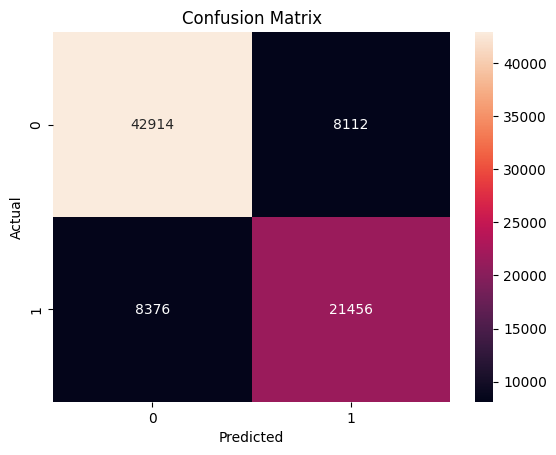

In [ ]:
# Evaluate the Model
preds = model.predict([X_test_q1, X_test_q2])
preds_binary = (preds > 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, preds_binary))
cm = confusion_matrix(y_test, preds_binary)

sns.heatmap(cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
# Save the Model
model.save("quora_question_similarity_model.h5")


In [ ]:
# Function to clean and tokenize custom input questions
def preprocess_question(question, tokenizer, max_len=30):
    question = clean_text(question)
    seq = tokenizer.texts_to_sequences([question])
    return pad_sequences(seq, maxlen=max_len)

# Function to predict if two questions are duplicates
def predict_duplicate(question1, question2, model, tokenizer):
    q1 = preprocess_question(question1, tokenizer)
    q2 = preprocess_question(question2, tokenizer)

    prediction = model.predict([q1, q2])[0][0]
    result = "Duplicate" if prediction > 0.5 else "Not Duplicate"

    print(f"Question 1: {question1}")
    print(f"Question 2: {question2}")
    print(f"Prediction: {result} (Confidence: {prediction:.4f})")


In [ ]:
#Test case-1 Which are similar
q1 = "How can I learn Python fast?"
q2 = "What is the quickest way to master Python?"

predict_duplicate(q1, q2, model, tokenizer)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Question 1: How can I learn Python fast?
Question 2: What is the quickest way to master Python?
Prediction: Duplicate (Confidence: 0.8320)


In [ ]:
# Test case-2 which are not similar
q1 = "How can I learn Python fast?"
q2 = "What is the quickest way to reach mount kilash?"

predict_duplicate(q1, q2, model, tokenizer)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Question 1: How can I learn Python fast?
Question 2: What is the quickest way to reach mount kilash?
Prediction: Not Duplicate (Confidence: 0.0440)
